In [1]:
import os, sys, copy, time, math, random, numbers, itertools, tqdm, importlib, re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rasterio
import torch

from sklearn import metrics
from skimage import transform as trans
from pathlib import Path
from collections.abc import Sequence
from datetime import datetime, timedelta
from scipy.ndimage import rotate
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
module_path = os.path.abspath(os.path.join('../src'))
sys.path.insert(0, module_path)

In [3]:
from custom_dataset import *
from utils import *
from models.unet import *
from model_compiler import *

In [4]:
# chips_multi_filtered
# ["v_flip", "h_flip", "d_flip", "rotate", "resize", "shift_brightness"]
# "/home/data/chkpt/Unet_final_state.pth"


config = {
    # Custom dataset params
    "src_dir": "/home/data",
    "train_dataset_name": "chips_filtered",
    "train_csv_path": "/home/workdir/train_ids.csv",
    "val_csv_path": "/home/workdir/val_ids.csv",
    "test_csv_path": "/home/workdir/test_ids.csv",
    "split_ratio": 0.8,
    "apply_normalization": True,
    "normal_strategy": "z_value",
    "stat_procedure": "gpb",
    "global_stats": {
        "min": np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0] * 3),
        "max": np.array([300.0, 350.0, 500.0, 800.0, 900.0, 850.0] * 3),
        "mean": np.array([
            524.299965, 852.201097, 987.414649, 
            2948.727491, 2712.733024, 1827.229407
        ] * 3),
        "std": np.array([
            294.751052, 370.654275, 596.312886, 
            858.965608, 955.384411, 938.537931
        ] * 3)
    },
    "transformations": [
        "v_flip", "h_flip", "d_flip", "rotate" 
        ],
    "aug_params": {
        "scale_factor": (0.75, 1.3),
        "rotation_degree": (-180, -90, 90, 180),
        "bshift_gamma_range": (0.2, 2),
        "bshift_subs": (6, 6, 6),
        "patch_shift": True
    },
    # DataLoader
    "train_BatchSize": 10,
    "val_test_BatchSize": 3,
    # Model initialization params
    "n_classes": 17,
    "input_channels": 18,
    "filter_config": (64, 128, 256, 512, 1024, 1024),
    "use_skipAtt": False,
    "train_dropout_rate": 0.15,
    # Model compiler params
    "working_dir": "/home/workdir",
    "out_dir": "output2",
    "class_mapping": {
        0:"Unknown", 1: "Shrubland", 2: "Grassland/Pasture", 
        3: "Forest", 4: "Corn", 5:"Soybeans", 6: "Wetlands",
        7: "Developed", 8:"Open Water", 9: "Winter Wheat", 
        10: "Other Hay/Non Alfalfa", 11: "Alfalfa",
        12: "Fallow/Idle Cropland", 13: "Barren", 
        14: "Cotton", 15: "Sorghum", 16:"Other"
    },
    "gpuDevices": [0],
    "init_type": "kaiming",
    "params_init": "/home/data/chkpt/Unet_final_state.pth",
    "freeze_params": None,
    # Model fitting
    "epochs": 75,
    "optimizer": "sam",
    "LR": 0.01,
    "LR_policy": "PolynomialLR",
    "criterion": ("TverskyFocalLoss(weight=[0.02018159, 0.00586021, 0.0075782,"
              "0.00614043, 0.00830566, 0.00931833, 0.00985327, 0.04378487,"
              "0.01287548, 0.02433819, 0.01946475, 0.01900336, 0.74793044,"
              "0.02536211, 0.0293618, 0.01064128], ignore_index=0, gamma=0.9)"),
    "momentum": 0.95,
    "resume": False,
    "resume_epoch": None,
    "lr_prams": {
        # StepLR & MultiStepLR
        "step_size": 3,
        "milestones": [5, 10, 20, 35, 50, 70, 90],
        "gamma": 0.98,
        # ReduceLROnPlateau
        "mode": "min",
        "factor": 0.8,
        "patience": 3,
        "threshold": 0.0001,
        "threshold_mode": "rel",
        "min_lr": 3e-6,
        # PolynomialLR
        "max_decay_steps": 50,
        "min_learning_rate": 1e-5,
        "power": 0.85,
        # CyclicLR
        "base_lr": 3e-5,
        "max_lr": 0.01,
        "step_size_up": 1100,
        "mode": "triangular"
    },
    # Model accuracy evaluation
    "val_metric_fname" : "validate_metrics_global_mm_lab.csv"   
}


### Steps for training and finetuning

In [ ]:
# STEP 1-1
# Read the input dataset for training, pre-process it, and generate a 'torch.utils.Dataset' object 
# that can be accepted to get loaded into the model.
train_dataset = CropData(src_dir=config["src_dir"],
                         usage="train",
                         dataset_name=config["train_dataset_name"],
                         csv_path=config["train_csv_path"],
                         apply_normalization=config["apply_normalization"],
                         normal_strategy=config["normal_strategy"],
                         stat_procedure=config["stat_procedure"],
                         global_stats=config["global_stats"],
                         trans=config["transformations"], 
                         **config["aug_params"])

In [ ]:
# OPTIONAL
show_random_patches(train_dataset, sample_num=3, rgb_bands=(3, 2, 1))

In [ ]:
# OPTIONAL
# Check the distribution of categories in a dataset
labels_count = get_labels_distribution(train_dataset, num_classes=14, ignore_class=0)
plot_labels_distribution(labels_count)

In [ ]:
# STEP 1-2
# Batchify the training dataset and put it on the defined 'Device'.
train_loader = DataLoader(train_dataset,
                          batch_size=config["train_BatchSize"], 
                          shuffle=True)

In [ ]:
# STEP 1-3
# Read the input dataset for validation, pre-process it and generate a 'torch.utils.Dataset' object 
# that can be accepted to get loaded into the model.
val_dataset = CropData(src_dir=config["src_dir"],
                       usage="validation",
                       dataset_name=config["train_dataset_name"],
                       csv_path=config["val_csv_path"],
                       apply_normalization=config["apply_normalization"],
                       normal_strategy=config["normal_strategy"],
                       stat_procedure=config["stat_procedure"],
                       global_stats=config["global_stats"],)

In [ ]:
total_pixels = 0
total_zero_pixels = 0

for img_chips, labels in val_dataset:
    total_pixels += labels.nelement()
    total_zero_pixels += (labels == 0).sum().item()

percentage_zero = (total_zero_pixels / total_pixels) * 100
print(f"Percentage of zero pixels: {percentage_zero} %")

In [ ]:
# OPTIONAL
# Check the distribution of categories in a dataset
labels_count = get_labels_distribution(val_dataset)
plot_labels_distribution(labels_count)

In [ ]:
# STEP 1-4
# Batchify the validation dataset and put it on the defined 'Device'.
val_loader = DataLoader(val_dataset, 
                        batch_size=config["val_test_BatchSize"], 
                        shuffle=False)

In [ ]:
# STEP 2
# Initialize the model
model = Unet(n_classes=config["n_classes"], 
             in_channels=config["input_channels"], 
             use_skipAtt=config["use_skipAtt"],
             filter_config=config["filter_config"],
             dropout_rate=config["train_dropout_rate"])

In [ ]:
# STEP 3
# Compile the model as vanilla or pre-trained object with 'fit', 'save', 'accuracy_evaluation'
# and 'inference' methods. It also has checkpointing and resume capabilities and generates 
# tensorboard reports and graphs.
compiled_model = ModelCompiler(model,
                               working_dir=config["working_dir"],
                               out_dir=config["out_dir"],
                               num_classes=config["n_classes"],
                               inch=config["input_channels"],
                               class_mapping=config["class_mapping"],
                               gpu_devices=config["gpuDevices"],
                               model_init_type=config["init_type"], 
                               params_init=config["params_init"],
                               freeze_params=config["freeze_params"])

In [ ]:
# STEP 4
# train and validate the model for the defined number of epochs
compiled_model.fit(train_loader,
                   val_loader, 
                   epochs=config["epochs"], 
                   optimizer_name=config["optimizer"], 
                   lr_init=config["LR"],
                   lr_policy=config["LR_policy"], 
                   criterion=config["criterion"], 
                   momentum=config["momentum"],
                   resume=config["resume"],
                   resume_epoch=config["resume_epoch"],
                   **config["lr_prams"])

In [ ]:
# STEP 5
# Same model parameters
compiled_model.save(save_object="params")

In [ ]:
# STEP 6
# Generate the accuracy metrics
metrics = compiled_model.accuracy_evaluation(val_loader, filename=config["val_metric_fname"])

### Steps for prediction

In [5]:
test_dataset = CropData(src_dir=config["src_dir"],
                       usage="inference",
                       dataset_name=config["train_dataset_name"],
                       csv_path=config["test_csv_path"],
                       apply_normalization=config["apply_normalization"],
                       normal_strategy=config["normal_strategy"],
                       stat_procedure=config["stat_procedure"],
                       global_stats=config["global_stats"],)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.26it/s]

------ inference dataset with 9 patches created ------


In [6]:
def meta_handling_collate_fn(batch):
    images = []
    labels = []
    img_ids = []
    img_metas = []

    # Unpack elements from each sample in the batch
    for sample in batch:
        images.append(sample[0])
        labels.append(sample[1])
        img_ids.append(sample[2])
        img_metas.append(sample[3])  # append the dict to the list

    # Stack images and labels into a single tensor
    images = torch.stack(images, dim=0)
    labels = torch.stack(labels, dim=0)
    
    return images, labels, img_ids, img_metas


test_loader = DataLoader(test_dataset, 
                        batch_size=config["val_test_BatchSize"], 
                        shuffle=False,
                        collate_fn=meta_handling_collate_fn)

In [ ]:
images, labels, img_ids, img_metas = next(iter(test_loader))

In [ ]:
img_metas[0]

In [ ]:
img_metas["transform"] = [t.item() for t in img_metas["transform"]]

In [ ]:
t = img_metas["transform"]
len(t)

In [7]:
model = Unet(n_classes=config["n_classes"], 
             in_channels=config["input_channels"], 
             use_skipAtt=config["use_skipAtt"],
             filter_config=config["filter_config"],
             dropout_rate=config["train_dropout_rate"])

In [8]:
compiled_model = ModelCompiler(model,
                               working_dir=config["working_dir"],
                               out_dir=config["out_dir"],
                               num_classes=config["n_classes"],
                               inch=config["input_channels"],
                               class_mapping=config["class_mapping"],
                               gpu_devices=config["gpuDevices"],
                               model_init_type=config["init_type"], 
                               params_init=config["params_init"],
                               freeze_params=config["freeze_params"])

----------GPU available----------
total number of trainable parameters: 103.4M
---------- Pre-trained model compiled successfully ----------


In [9]:
compiled_model.inference(test_loader, out_dir=config["out_dir"])

---------------- Start prediction ----------------
Pred tile: 140_494 is written to output2
Pred tile: 153_487 is written to output2
Pred tile: 163_455 is written to output2
Pred tile: 169_612 is written to output2
Pred tile: 176_587 is written to output2
Pred tile: 227_269 is written to output2
Pred tile: 241_288 is written to output2
Pred tile: 308_526 is written to output2
Pred tile: 322_534 is written to output2
---------------- Prediction finished in 5s ----------------


In [22]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
import matplotlib.colors as mcolors

def plot_image_and_label(image_path, label_path, band_composite=(4,3,2), 
                         stretch=None, class_mapping=None):
    """
    Plots a loaded image and its corresponding label using matplotlib and 
    rasterio.plot.

    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the label file.
        stretch (str): A string specifying the contrast stretch to apply to the 
            image (e.g. 'linear', 'sqrt', or 'log').
        band_composite (tuple of int): A tuple specifying the band indices to 
            use for an RGB image (e.g. (3, 2, 1)).
        class_mapping (dict): A dictionary mapping class values to class names.

    Returns:
        None
    """
    # Open the image and label files
    with rasterio.open(image_path) as src:
        image_array = src.read()

    with rasterio.open(label_path) as src:
        label_array = src.read(1)

    # Set up the figure and axes
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    # Transpose the image_array if it's 3D and the first dimension is the smallest
    if (image_array.ndim == 3) and (image_array.shape[0] == np.min(image_array.shape)):
        image_array = image_array.transpose(1,2,0)
    
    image_size = [image_array.shape[0], image_array.shape[1]]
    label_size = [label_array.shape[0], label_array.shape[1]]

    # If a band composite is specified, create an RGB image
    red_band = image_array[:, :, band_composite[0] - 1] / np.max(image_array[:, :, band_composite[0] - 1])
    green_band = image_array[:, :, band_composite[1] - 1] / np.max(image_array[:, :, band_composite[1] - 1])
    blue_band = image_array[:, :, band_composite[2] - 1] / np.max(image_array[:, :, band_composite[2] - 1])

    # Stack the bands to create an RGB image
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

    # Apply the contrast stretch if specified
    if stretch:
        p_min, p_max = np.percentile(rgb_image, (2, 98))
        stretched = exposure.rescale_intensity(
            rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
        )
    else:
        stretched = rgb_image

    # Display the RGB image using matplotlib
    axs[0].imshow(stretched)
    
    # Add a title and axis labels
    axs[0].set_title('Image')
    axs[0].set_xlabel(f'# Column: {image_size[0]}')
    axs[0].set_ylabel(f'# Row: {image_size[1]}')
    axs[0].axis('off')
    axs[0].set_aspect('equal')

    # If class mapping is provided, create a colormap and a colorbar for the classes
    if class_mapping is not None:
        # Create a color map for your classes
        cmap = mcolors.ListedColormap(['black', 'mediumseagreen', 'lime', 'forestgreen', 'yellow', 
                                        'yellowgreen', 'cyan', 'crimson', 'darkblue', 'wheat', 
                                        'goldenrod', 'gold', 'lightsteelblue', 'sandybrown', 
                                        'lightgray', 'darkorange', 'red'])

    # Plot label chip
    im = axs[1].imshow(label_array, cmap=cmap)
    axs[1].set_title('Label')
    axs[1].set_xlabel(f'# Column: {label_size[0]}')
    axs[1].set_ylabel(f'# Row: {label_size[1]}')

    # Create colorbar after imshow
    if class_mapping is not None:
        colorbar = fig.colorbar(im, ax=axs[1], ticks=list(class_mapping.keys()), label='class')
        colorbar.ax.set_yticklabels(list(class_mapping.values()))  # set the colorbar labels to be the class names

    # Show the plot
    axs[1].axis('off')
    axs[1].set_aspect('equal')
    plt.show()


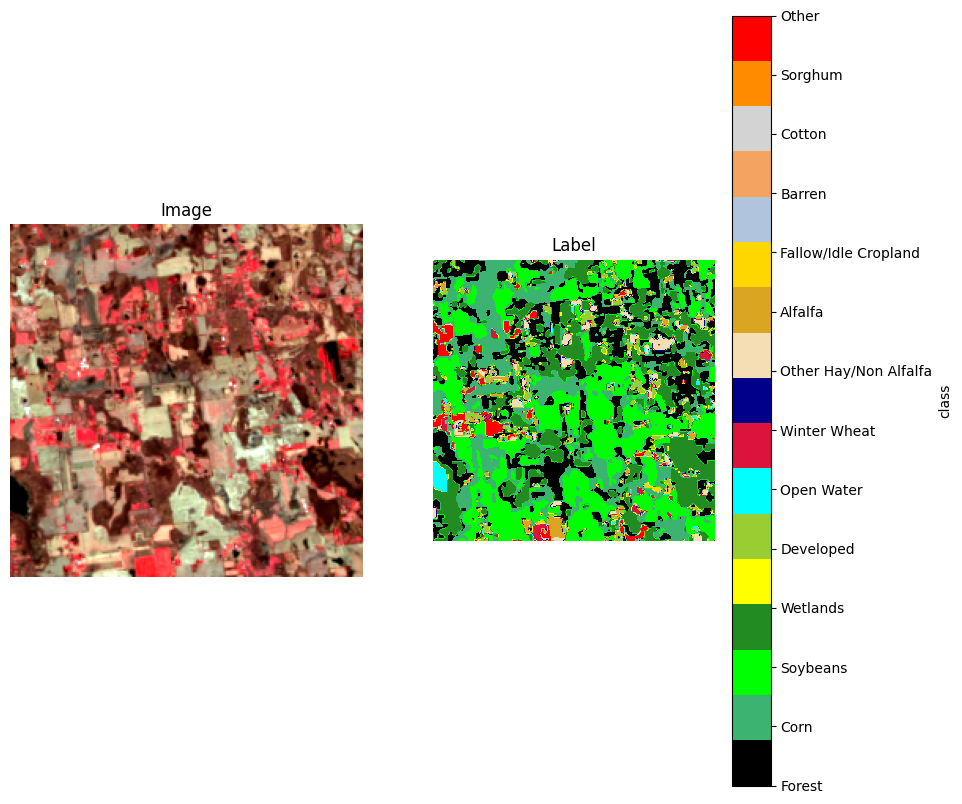

In [23]:
image_path = "/home/data/chips_filtered/chip_140_494_merged.tif"
label_path = "/home/workdir/output2/hardened_prob/crisp_id_140_494.tif"
plot_image_and_label(image_path, label_path, band_composite=(4,3,2), stretch="linear", class_mapping=config["class_mapping"])

In [ ]:
data_path = "/home/data/chips_filtered/chip_140_494_merged.tif"

In [ ]:
 with rasterio.open(data_path, "r") as src:
     meta = src.meta
     img = src.read()

In [ ]:
meta

In [ ]:
type(meta['crs'])

In [ ]:
meta["crs"] = meta["crs"].to_string()

In [ ]:
meta["crs"] = meta["crs"].to_string()